Name: **Chhavi Gupta**  
Email: `cgupta1_be21@thapar.edu`  
Roll No: **102103322**  
Group: **4CO12**  
Start Timestamp: 20240911-1000

## Question

Consider the paper: <https://arxiv.org/abs/1804.03209>

  1. Read and summarise the paper in about 50 words.
  2. Download the dataset in the paper, statistically analyse and
     describe it, so that it may be useful for posterity. (Include code
     snippets in your .ipynb file to evidence your analysis.)
  3. Train a classifier so that you are able to distinguish the commands
     in the dataset.
  4. Report the performance results using standard benchmarks.
  5. Record about 30 samples of each command in your voice and create a
     new dataset (including a new user id for yourself).  You may use a
     timer on your computer to synchronise.
  6. Fine tune your classifier to perform on your voice.
  7. Report the results.

## Paper Summary

The Speech Commands dataset contains 105,829 utterances of 35 words from 2,618 speakers, using hashed speaker IDs for privacy. It features a variety of background noise samples and supports automated and manual quality control methods. Evaluation metrics include Top-One Error and Streaming Accuracy, assessing model performance in keyword recognition and continuous audio streams. Version 2 improves accuracy over Version 1 and provides data for model optimization, noise tolerance, and application development. The dataset is accessible for reproducible research and diverse model benchmarking.
*italicized text*

## Solution

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pathlib
from pathlib import Path
import shutil
import json
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
def download_speech_commands():
    data_dir = pathlib.Path('data/speech_commands_v0.02')
    origin = 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz'

    if not data_dir.exists():
        tf.keras.utils.get_file(
            'speech_commands_v0.02.tar.gz',
            origin=origin,
            extract=True,
            cache_dir='.',
            cache_subdir='data/speech_commands_v0.02')
    else:
        print('Speech Commands dataset already exists')

    try:
        shutil.rmtree(str(data_dir) + '/_background_noise_')
    except OSError as e:
        print('Error: %s - %s.' % (e.filename, e.strerror),
              'Check if directory has already been removed.')

    zip_file = str(data_dir) + '/speech_commands_v0.02.tar.gz'
    if os.path.exists(zip_file):
        os.remove(zip_file)

download_speech_commands()

2428923189/2428923189 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


In [ ]:
def plot_spectrogram(Y, sr, hop_length, y_axis='linear'):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis='time', y_axis=y_axis)
    plt.colorbar(format='%+2.f')
    plt.xlabel('Time (seconds)', fontsize=18, labelpad=20)
    plt.ylabel('Frequency (Hz)', fontsize=18, labelpad=20)
    plt.show()

target_sample = 'data/speech_commands_v0.02/zero/0a2b400e_nohash_0.wav'
sc_sample, sr = librosa.load(target_sample)
print('Audio sample: Zero')
ipd.display(ipd.Audio(sc_sample, rate=sr))

Audio sample: Zero


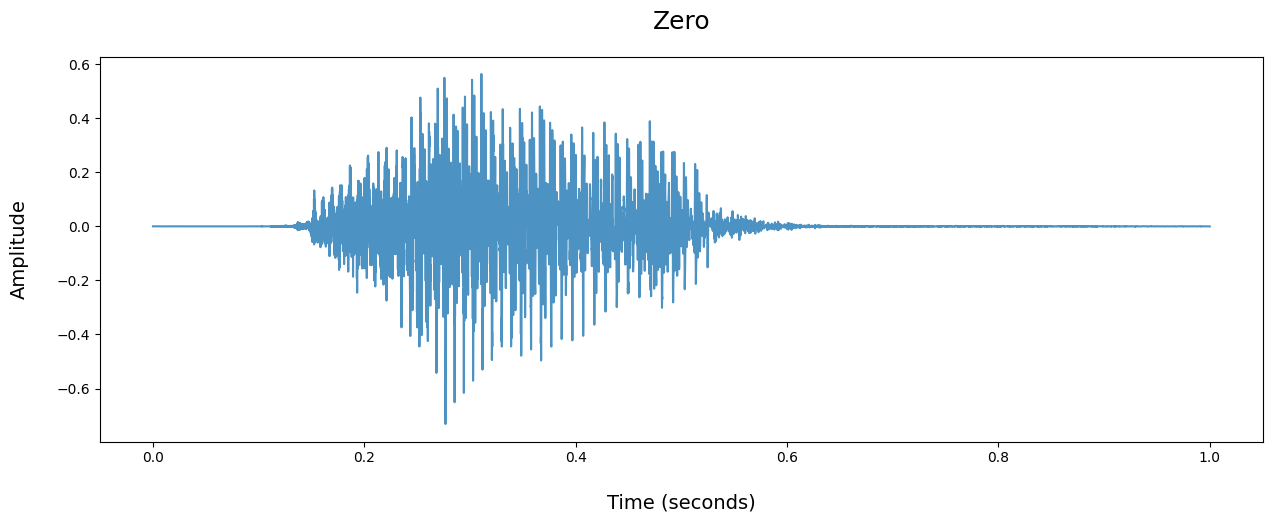

In [ ]:
plt.figure(figsize=(15, 5))
plt.title('Zero', fontsize=18, pad=20)
plt.plot(np.linspace(0, len(sc_sample) / sr, num=len(sc_sample)), sc_sample, alpha=0.8)
plt.xlabel('Time (seconds)', fontsize=14, labelpad=20)
plt.ylabel('Amplitude', fontsize=14, labelpad=20)
plt.show()



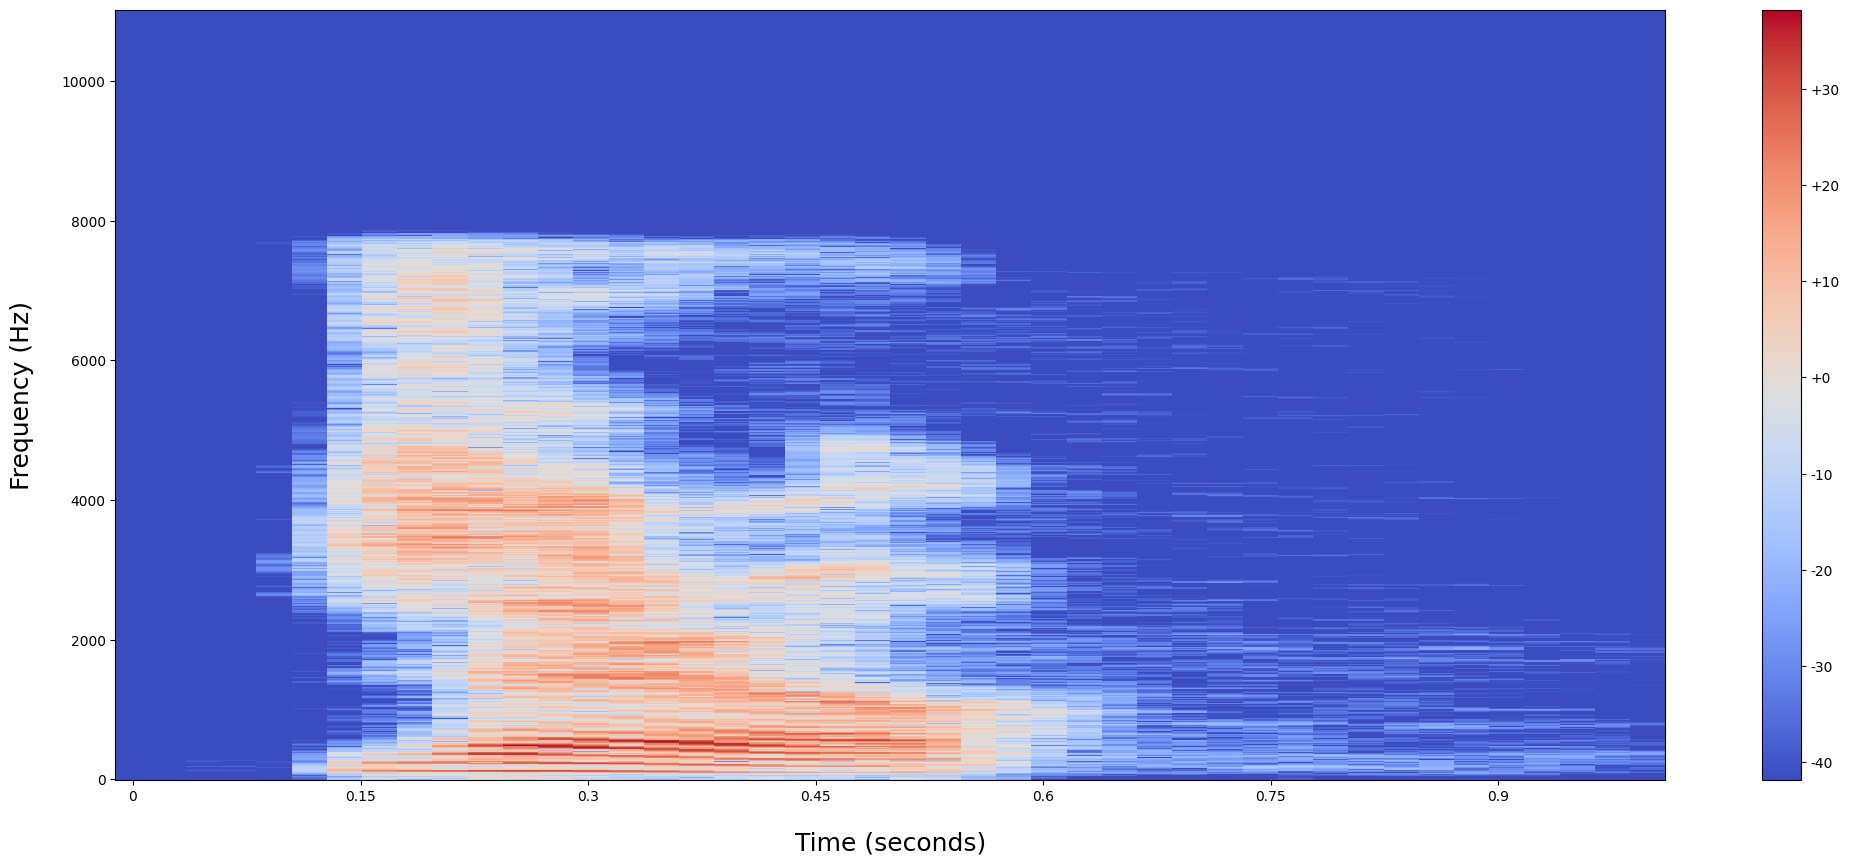

In [ ]:
hop_length = 512
n_fft = 2048
S_sc_sample = librosa.stft(sc_sample, n_fft=n_fft, hop_length=hop_length)
Y_sc_sample = np.abs(S_sc_sample) ** 2
Y_log_sc_sample = librosa.power_to_db(Y_sc_sample)
plot_spectrogram(Y_log_sc_sample, sr, hop_length)

In [ ]:
def preprocess_dataset(dataset_path, json_path, feature, num_samples, num_mfcc=13, n_fft=2048, hop_length=512):
    if feature == 'mel_specs':
        data = {'mapping': [], 'labels': [], 'mel_specs': [], 'files': []}
    else:
        data = {'mapping': [], 'labels': [], 'MFCCs': [], 'files': []}

    for i, (dirpath, _, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            label = dirpath.split('/')[-1]
            data['mapping'].append(label)
            print("\nProcessing: '{}'".format(label))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path)

                if len(signal) >= num_samples:
                    signal = signal[:num_samples]

                    if feature == 'mel_specs':
                        mel_specs = librosa.feature.melspectrogram(signal, sample_rate, n_fft=n_fft, hop_length=hop_length)
                        data['mel_specs'].append(mel_specs.T.tolist())
                    else:
                        MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        data['MFCCs'].append(MFCCs.T.tolist())

                    data['labels'].append(i-1)
                    data['files'].append(file_path)
                    print("{}: {}".format(file_path, i-1))

    with open(json_path, 'w') as file_path:
        json.dump(data, file_path, indent=4)


In [ ]:
def load_data(data_path, feature):
    with open(data_path, 'r') as file_path:
        data = json.load(file_path)
    X = np.array(data[feature])
    y = np.array(data['labels'])
    print('Datasets loaded...')
    return X, y

In [ ]:
def create_train_test(data_path, feature, test_size=0.2, val_size=0.2):
    X, y = load_data(data_path, feature)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
sc_dataset_path = 'data/speech_commands_v0.02'
sc_json_path = 'speech_commands_data.json'
num_samples = 22050
speechcommands = preprocess_dataset(sc_dataset_path, sc_json_path, 'MFCCs', 22050)


Streaming output truncated to the last 5000 lines.
data/speech_commands_v0.02/yes/b41a92a3_nohash_0.wav: 33
data/speech_commands_v0.02/yes/b8874962_nohash_3.wav: 33
data/speech_commands_v0.02/yes/8eb4a1bf_nohash_3.wav: 33
data/speech_commands_v0.02/yes/f5496439_nohash_1.wav: 33
data/speech_commands_v0.02/yes/b414c653_nohash_1.wav: 33
data/speech_commands_v0.02/yes/02ade946_nohash_4.wav: 33
data/speech_commands_v0.02/yes/92521ccc_nohash_0.wav: 33
data/speech_commands_v0.02/yes/db24628d_nohash_2.wav: 33
data/speech_commands_v0.02/yes/0137b3f4_nohash_2.wav: 33
data/speech_commands_v0.02/yes/29dce108_nohash_0.wav: 33
data/speech_commands_v0.02/yes/2927c601_nohash_4.wav: 33
data/speech_commands_v0.02/yes/94d370bf_nohash_3.wav: 33
data/speech_commands_v0.02/yes/ce9410da_nohash_0.wav: 33
data/speech_commands_v0.02/yes/76b58705_nohash_0.wav: 33
data/speech_commands_v0.02/yes/ddedba85_nohash_15.wav: 33
data/speech_commands_v0.02/yes/ace072ba_nohash_1.wav: 33
data/speech_commands_v0.02/yes/89947

AttributeError: 'NoneType' object has no attribute 'head'

In [ ]:

def save_model(save_model, save_path):
    save_model.save(save_path)
def reformat_y(y):
    y = LabelEncoder().fit_transform(y)
    y = tf.keras.utils.to_categorical(y)
    return y

def model_performance(input_model,
                      input_train_X,
                      input_train_y,
                      input_test_X,
                      input_test_y
                     ):

    results_train = input_model.evaluate(input_train_X,
                                         input_train_y,
                                         verbose=0)

    results_test = input_model.evaluate(input_test_X,
                                        input_test_y,
                                        verbose=0)

    predictions = input_model.predict(input_test_X)

    conf_matrix = confusion_matrix(input_test_y.argmax(axis=1),
                                   np.round(predictions.argmax(axis=1)))

    print('CONFUSION MATRIX ------------------')
    print(conf_matrix)

    print('\nTRAIN METRICS ----------------------')
    print('Loss: {}'.format(results_train[0]))
    print('Accuracy: {}%'.format(np.round(results_train[1]*100), 2))

    print('\nTEST METRICS ----------------------')
    print('Loss: {}'.format(results_test[0]))
    print('Accuracy: {}%'.format(np.round(results_test[1]*100), 2))



In [ ]:
sc_data_path = "speech_commands_data.json"
(
    sc_X_train,
    sc_y_train,
    sc_X_val,
    sc_y_val,
    sc_X_test,
    sc_y_test,
) = create_train_test(sc_data_path, 'MFCCs')

Datasets loaded...


In [ ]:
def fit_model(model,
              epochs,
              batch_size,
              patience,
              X_train,
              y_train,
              X_val,
              y_val):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                      min_delta=0.001,
                                                      patience=patience,
                                                      mode='max')

    results = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    return results

In [ ]:
def build_crnn_model(input_shape, output_units, learning_rate=0.0001):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Reshape((-1, 64)))  # Reshape for RNN input

    model.add(tf.keras.layers.LSTM(128, return_sequences=True))
    model.add(tf.keras.layers.LSTM(128))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Dense(output_units, activation='softmax'))

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    return model

In [ ]:
def fit_model(model,
              epochs,
              batch_size,
              patience,
              X_train,
              y_train,
              X_val,
              y_val):

    # Define early stopping criteria
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                      min_delta=0.001,
                                                      patience=patience,
                                                      mode='max')

    # Fit the model
    results = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    return results

In [ ]:
sc_cnn_input_shape = (sc_X_train.shape[1], sc_X_train.shape[2], 1)
sc_output_units = 35
learning_rate = 0.0001

# Build CRNN model
crnn_model = build_crnn_model(sc_cnn_input_shape,
                               sc_output_units,
                               learning_rate=0.0001)

sc_epochs = 40
sc_batch_size = 64
sc_patience = 3

crnn_results = fit_model(crnn_model,
                         sc_epochs,
                      sc_batch_size,
                      sc_patience,
                      sc_X_train,
                      sc_train_y,
                      sc_X_val,
                      sc_val_y)






/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 42, 11, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 21, 5, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 19, 3, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 9, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 9, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 9, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 35)                  │           4,515 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 270,243 (1.03 MB)

 Trainable params: 270,243 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 97s 96ms/step - accuracy: 0.1763 - loss: 3.0395 - val_accuracy: 0.5727 - val_loss: 1.5603
Epoch 2/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 139s 93ms/step - accuracy: 0.5591 - loss: 1.5337 - val_accuracy: 0.6902 - val_loss: 1.0738
Epoch 3/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 146s 98ms/step - accuracy: 0.6718 - loss: 1.1292 - val_accuracy: 0.7386 - val_loss: 0.8806
Epoch 4/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 142s 97ms/step - accuracy: 0.7300 - loss: 0.9266 - val_accuracy: 0.7747 - val_loss: 0.7664
Epoch 5/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 144s 100ms/step - accuracy: 0.7666 - loss: 0.8024 - val_accuracy: 0.7936 - val_loss: 0.6855
Epoch 6/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 139s 96ms/step - accuracy: 0.7920 - loss: 0.7143 - val_accuracy: 0.8139 - val_loss: 0.6165
Epoch 7/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 149s 103ms/step - accuracy: 0.8088 - loss: 0.6452 - val_accuracy: 0.8251 - val_loss: 0.5831
Epoch 8/40
954/954 ━━━━━━━━━━━━━━━━━━━━ 137s 98ms/step - accuracy: 0.8278 - loss: 

In [ ]:
model_performance(crnn_model,
                  sc_X_train,
                  sc_train_y,
                  sc_X_test,
                  sc_test_y
                 )

597/597 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step
CONFUSION MATRIX ------------------
[[632   2   1 ...   0   0   1]
 [  9 608   1 ...   1   3   0]
 [  0   1 603 ...   9   0   1]
 ...
 [  0   0   1 ... 612   0   2]
 [  0   0   0 ...   0 711   1]
 [  0   0   0 ...   1   2 299]]

TRAIN METRICS ----------------------
Loss: 0.17094513773918152
Accuracy: 95.0%

TEST METRICS ----------------------
Loss: 0.43271276354789734
Accuracy: 89.0%


In [ ]:
save_model(crnn_model, 'final_model.h5')


In [ ]:
from sklearn.metrics import classification_report

preds = crnn_model.predict(sc_X_test)

sc_keywords = [
    'backward',
    'bed',
    'bird',
    'cat',
    'dog',
    'down',
    'eight',
    'five',
    'follow',
    'forward',
    'four',
    'go',
    'happy',
    'house',
    'learn',
    'left',
    'marvin',
    'nine',
    'no',
    'off',
    'on',
    'one',
    'right',
    'seven',
    'sheila',
    'six',
    'stop',
    'three',
    'tree',
    'two',
    'up',
    'visual',
    'wow',
    'yes',
    'zero']

print(classification_report(sc_test_y.argmax(axis=1),
                            preds.argmax(axis=1),
                            target_names=sc_keywords))

597/597 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step
              precision    recall  f1-score   support

    backward       0.92      0.92      0.92       690
         bed       0.96      0.89      0.92       686
        bird       0.92      0.86      0.89       705
         cat       0.90      0.86      0.88       694
         dog       0.89      0.85      0.87       364
        down       0.86      0.85      0.86       337
       eight       0.85      0.88      0.87       709
        five       0.92      0.90      0.91       726
      follow       0.83      0.90      0.86       343
     forward       0.93      0.92      0.92       698
        four       0.80      0.90      0.84       654
          go       0.88      0.91      0.90       745
       happy       0.88      0.90      0.89       312
       house       0.92      0.87      0.90       700
       learn       0.87      0.77      0.81       285
        left       0.88      0.91      0.90       366
      marvin       0.83      0.85     

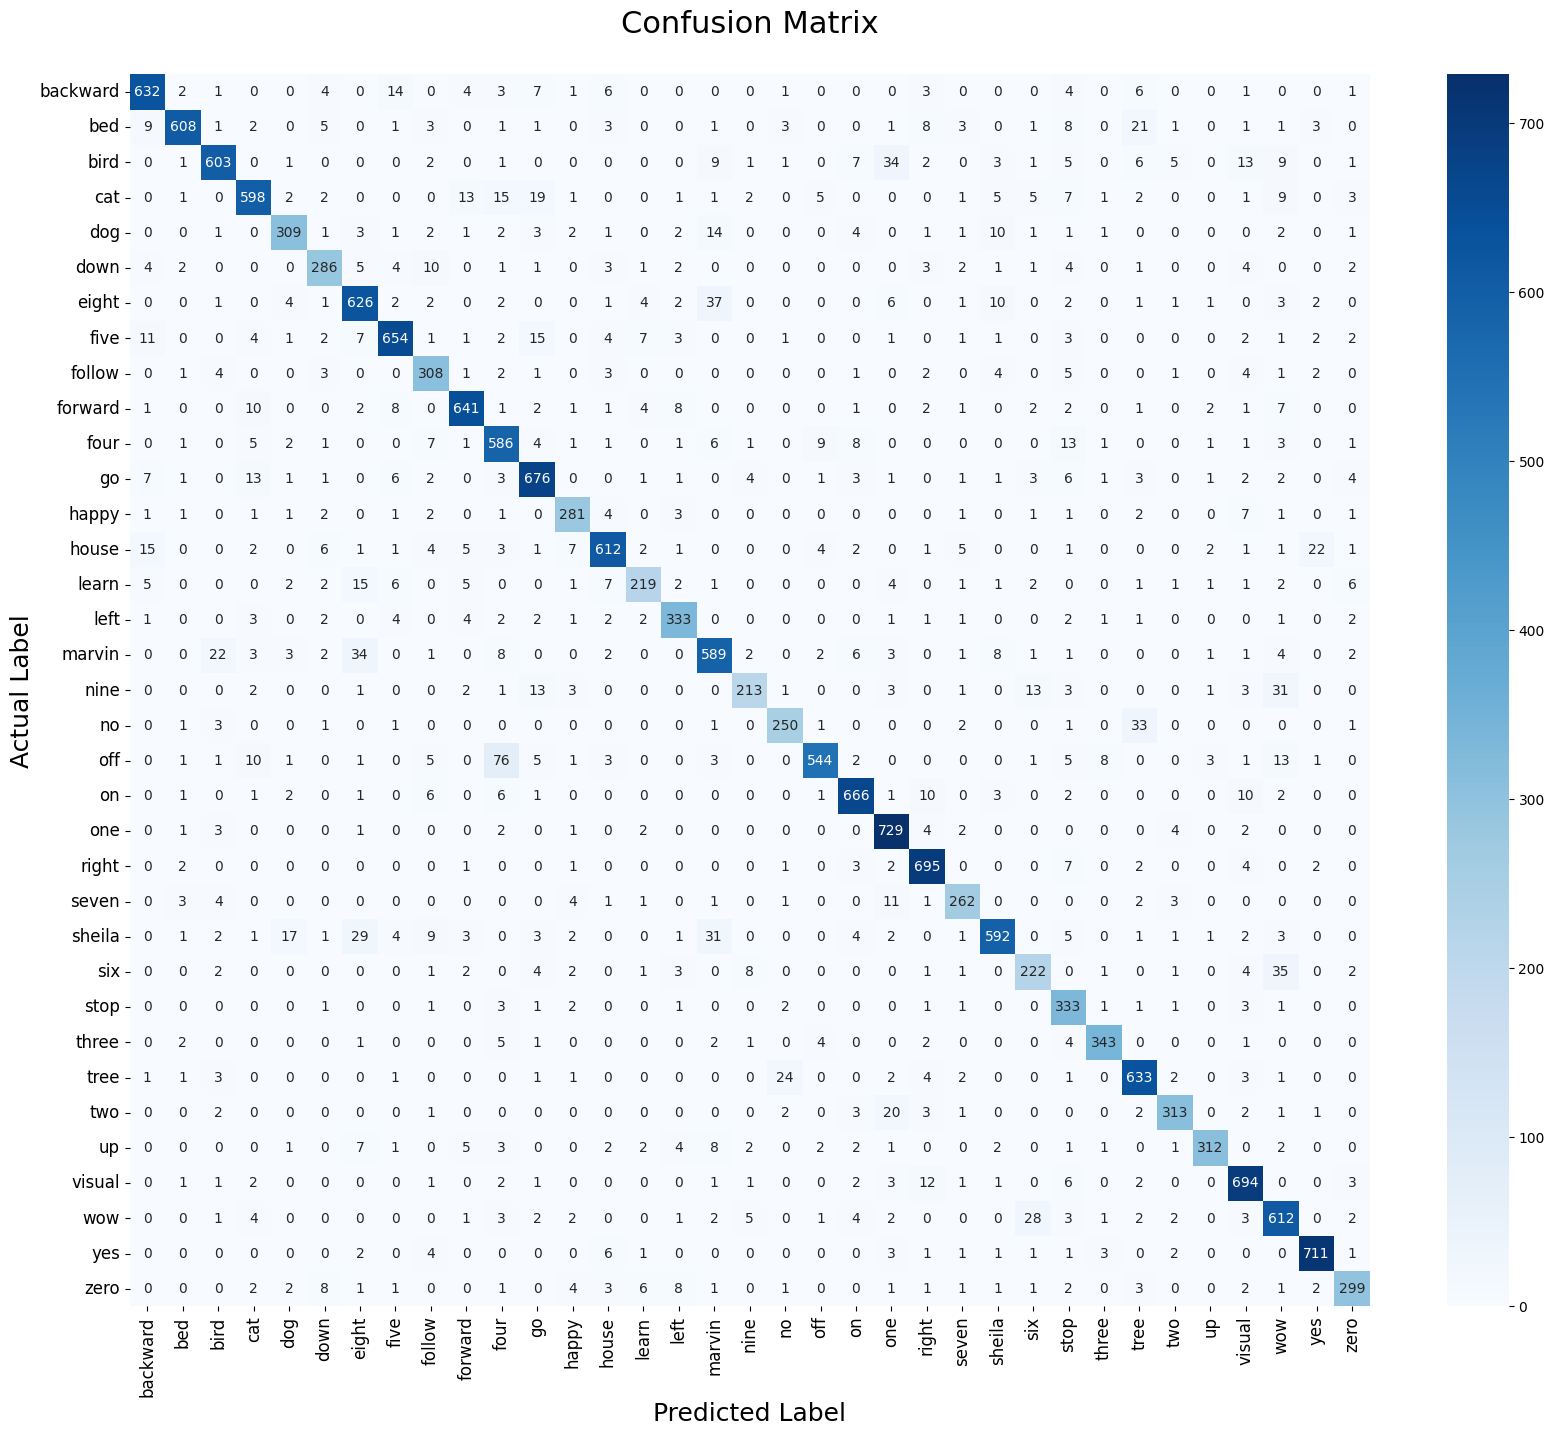

In [ ]:
cm = confusion_matrix(sc_test_y.argmax(axis=1),
                      np.round(preds.argmax(axis=1)))

plt.figure(figsize=(20,16))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix', fontsize=22, pad=30)
ax.set_xlabel('Predicted Label', fontsize=18)
ax.set_ylabel('Actual Label', fontsize=18)
ax.xaxis.set_ticklabels(sc_keywords, rotation=90, fontsize=12)
ax.yaxis.set_ticklabels(sc_keywords, rotation=0, fontsize=12)
plt.show();

## Test Case

In [ ]:
target_sample = '/content/stop_002.wav'
target_label = 'stop'
audio_sample, sr = librosa.load(target_sample)
print('Audio sample:', target_label)
ipd.Audio(audio_sample, rate=sr)

In [96]:
mfccs = librosa.feature.mfcc(y=audio_sample,
                             sr=sr,
                             n_mfcc=13,
                             n_fft=2048,
                             hop_length=512)

mfccs = mfccs.T
mfccs = mfccs[np.newaxis, ..., np.newaxis]

prediction = crnn_model.predict(mfccs)
predicted_index = np.argmax(prediction)

sc_keywords = [ 'backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight',
               'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left',
               'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six',
               'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

predicted_keyword = sc_keywords[predicted_index]
print('The word said is...', predicted_keyword, '!')



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
The word said is... stop !


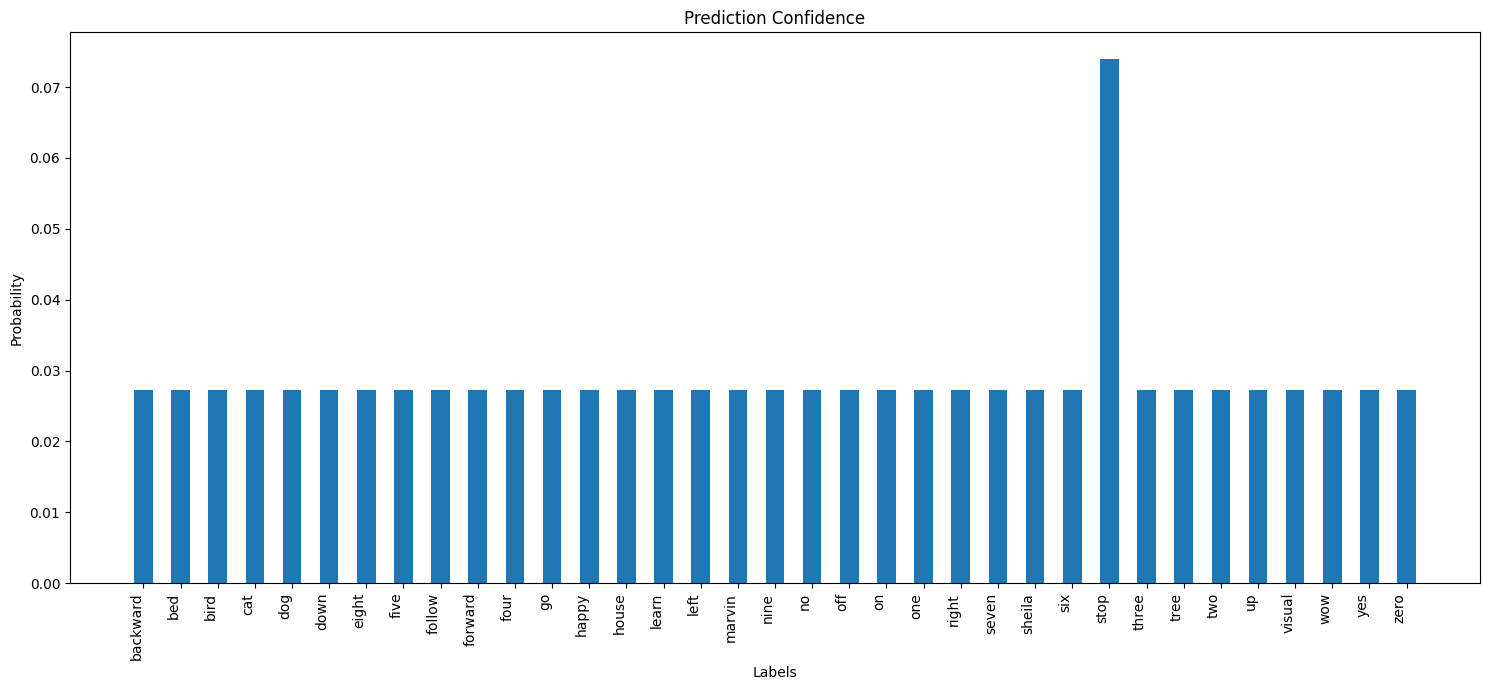

In [97]:
plt.figure(figsize=(15, 7))
plt.bar(sc_keywords, tf.nn.softmax(prediction[0]), width=0.5)
plt.xticks(rotation=90, ha='right')
plt.title('Prediction Confidence')
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.tight_layout()
plt.show()